In [1]:
import pandas as pd
import pvlib
from pvlib.location import Location
import matplotlib.pyplot as plt
import numpy as np
from sympy import*
from scipy.optimize import curve_fit
from scipy import integrate # indlæses også senere i selve opgaven

In [2]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "Min"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Højde er ca 50 m MOH

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:59", inclusive="left", freq=delta_tid, tz=tidszone
)

# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)


### Ny kode

In [3]:
theta_sol = np.deg2rad(solpos.loc["2024-04-20"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-04-20"].azimuth.values)

In [21]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    L·B = 1.63 # længde gange bredde   
    n = 0.185 * L·B  # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer panelet til den kommer ind i et andet kredsløb
    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot_products = n * np.sum(u_s * u_p, axis=-1)
    return np.maximum(dot_products, 0)

In [14]:
flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

In [15]:
from scipy import integrate

energi = integrate.simpson(flux_array, dx=60)  # i [W·s] eller Joule

In [16]:
energi_Wh = energi / 3600
energi_Wh

0.8947226741301545

In [34]:
phi_panel = np.deg2rad(180)
energier = []
wh_energier = []

for vinkel in range(0, 91):  # 0° til 90°
    theta_panel = np.deg2rad(vinkel)
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
    energi = integrate.simpson(flux_array, dx=60)
    energier.append(energi)
    wh_energier.append(energi/3600)


energier # i enheden Joule pr sekunder
wh_energier # i enheden kWh 

[1.9452697447406808,
 1.9672226744095203,
 1.9887339219509457,
 2.0097865921495184,
 2.030368530924662,
 2.0504583267809573,
 2.0700424143550262,
 2.089107920201811,
 2.107642215548396,
 2.1256329262504585,
 2.1430679426689725,
 2.159941589157176,
 2.1762446646031393,
 2.1919602321700524,
 2.2070854874265398,
 2.2216044584338657,
 2.2355252516501536,
 2.2488264885736244,
 2.2615039552446428,
 2.27355560727933,
 2.284972971725629,
 2.295744976829409,
 2.305879872069957,
 2.315359857721487,
 2.324181779831665,
 2.3323506146157627,
 2.3398493745151927,
 2.346687484070725,
 2.352847937825861,
 2.35834128273135,
 2.3631521350062363,
 2.3672897716393617,
 2.3707404071257825,
 2.3735130545816086,
 2.375595528146586,
 2.376997287901708,
 2.3777059214010197,
 2.3777312156903907,
 2.3770619789471867,
 2.3757077997935894,
 2.3736586851842376,
 2.370924022311773,
 2.3674961182107017,
 2.3633830200770896,
 2.3585817067415586,
 2.3530929134346406,
 2.3469217874330695,
 2.340062474206468,
 2.33252363

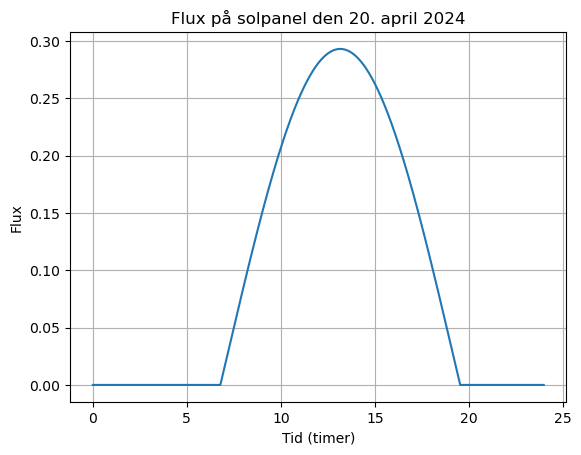

In [18]:
time_index = solpos.loc["2024-04-20"].index
time_array = np.array([t.hour + t.minute/60 for t in time_index])

flux = solar_panel_projection(theta_sol, phi_sol, np.deg2rad(30), np.deg2rad(180))
plt.plot(time_array, flux)
plt.xlabel("Tid (timer)")
plt.ylabel("Flux")
plt.title("Flux på solpanel den 20. april 2024")
plt.grid()
plt.show()

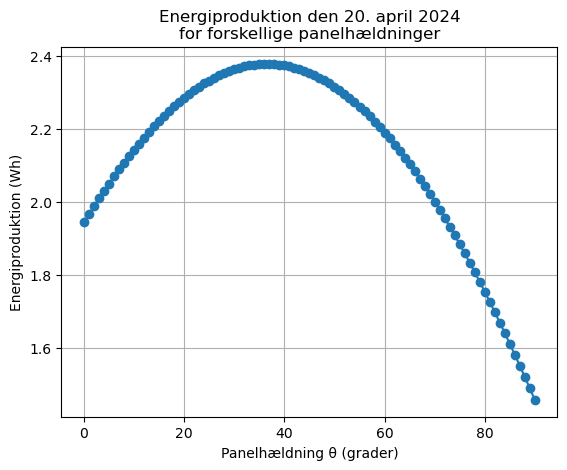

In [35]:
hældninger = np.arange(0, 91)  # 0° til 90°
plt.plot(hældninger, wh_energier, marker='o')
plt.xlabel("Panelhældning θ (grader)")
plt.ylabel("Energiproduktion (Wh)")
plt.title("Energiproduktion den 20. april 2024\nfor forskellige panelhældninger")
plt.grid(True)
plt.show()

In [ ]:
np.argmax(wh_energier)

37